# Fit to a curve in a logarithmic plane

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

Consider the following set of points:

In [3]:
df=pd.read_csv('xenon.csv')

In [4]:
df.columns

Index([u'M', u'sigma'], dtype='object')

In [5]:
x=df.columns[0]
y=df.columns[1]

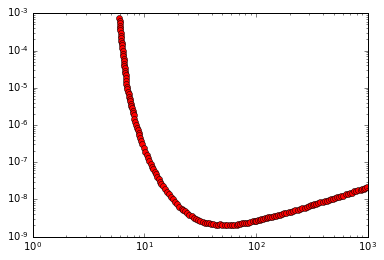

In [6]:
plt.loglog(df[x],df[y],'ro')

## Exponential fit
The curve can be decomposed in approximately straight lines. In the $(\log x,\log y)$-plan one straight line is described by $y = Ae^{Bx}$ for some $A$ and $B$.

From: http://stackoverflow.com/a/3433503/2268280:

For fitting $y = Ae^{Bx}$, take the logarithm of both side gives $\log y = \log A + Bx$. So just fit $\log y$ against $x$.
### Straight segments
Will be obtained by trial and error. If one segment is not good enough it will be possible to delete it.
## Object design
The object, e,g: `fit`, will be initialized with the `x` and `y` arrays:
It will have the following methods
* `add_segment(xmin,xmax,ShowPlot=True)`
* `del_last_segment()`
* `to_csv(file)` to write the data of the fit
* `read_csv(file)` to read the data with the fit

Once the fit have been build or read it can be used just by calling the object with a point or an array

In [1]:
%%writefile straightfits.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
class straightfits(object):
    '''The curve in a loglog plane can be decomposed in approximately straight lines. 
       In the $(\log x,\log y)$-plane one straight line is described by $y = Ae^{Bx}$ for some $A$ and $B$.

       From: http://stackoverflow.com/a/3433503/2268280:

       For fitting $y = Ae^{Bx}$, take the logarithm of both side gives $\log y = \log A + Bx$. 
       So just fit $\log y$ against $x$.
    '''
    A=np.array(0)
    B=np.array(0)
    corners=np.array([])
    def __init__(self,x=[],y=[]):
        self.x=np.asarray(x)
        self.y=np.asarray(y)
        if self.x.shape[0]>0:
            self.corners=np.append(self.corners,self.x[0])
    def __getitem__(self, key):
        if key=='x':
            return self.x
        elif key=='y': 
            return self.y
        elif key=='corners':
            return self.corners
        else:
            sys.exit('Not key: %s',%key)
            
    def add_segment(self,xmin,xmax,ShowPlot=True,verbose=False):
        '''Add one straight segment to the logarhitmic fit
           between xmin and xmax,
           WARNING: xmax not inclued in the range of the fit
           ShowPlot to check the fit
        '''
        df=pd.DataFrame()
        df['x']=self.x
        df['y']=self.y
        self.corners=np.append(self.corners,xmax)
        d=df[np.logical_and(df.x>=xmin,df.x<=xmax)]
        z = np.polyfit(d.x, np.log(d.y), 1)
        p = np.poly1d(z)
        if verbose:
            print 'logy=',p
        self.A=np.append( self.A,np.exp(p[0]) )
        self.B=np.append( self.B,p[1])
        if ShowPlot:
            xlin=np.linspace(xmin,xmax)
            plt.semilogy(d.x,d.y,'ro')
            plt.semilogy(xlin,self.A[-1]*np.exp(self.B[-1]*xlin))
        return self.A[-1],self.B[-1]
    def delete_last_segment(self):
        '''Delete tha last saved straight segment'''
        self.A=self.A[:-1]
        self.B=self.B[:-1]
        self.corners=self.corners[:-1]
    
    def to_csv(self,csvfile):
        '''
        Save the fit data to a csv file with colums:
        A,B,corners
        where: $y = Ae^{Bx}$
        '''
        df=pd.DataFrame()
        df['A']=self.A
        df['B']=self.B
        df['corners']=self.corners
        df.to_csv(csvfile,index=False)
        
    def read_csv(self,csvfile):
        '''
        Recover fitted data from a csv file with colums:
        A,B,corners
        where: $y = Ae^{Bx}$
        '''
        df=pd.read_csv(csvfile)
        self.A=df.A
        self.B=df.B
        self.corners=df.corners
        
    def __call__(self,x):
        '''
        Given an array A and another array B defined by the
        values of x in corners, obtain the several values
        of $y = Ae^{Bx}$ for any x.
        x can be a float or an array of floats
        '''
        xa=np.asarray(x)
        if not np.asarray(x).shape:
            xa=np.asarray([x])
        
        limit=np.array([])
        imax=self.corners.shape[0]-1
        for xx in xa:
            for i in range(1,imax+1):
                if xx>=self.corners[i-1] and xx<self.corners[i]:
                    limit = np.append( limit,self.A[i]*np.exp(self.B[i]*xx) )
                if xx<self.corners[0] or xx>=self.corners[imax]:
                    limit = np.append( limit,0.0 )	
                    sys.exit('ERROR: Out of range')
                   
        if limit.shape[0]==1:
            limit=limit[0]
        return limit
        

Overwriting straightfits.py


Intialize class and add first segment. Add a point with the object function and also an array

[  5.41287364e-04   1.53158687e-04   4.33366544e-05   1.22622206e-05]
0.000541287364003
[ 5.94872466  7.        ]
[        0.          50021069.28343865]
[ 0.         -4.20825252]
1.22622206458e-05


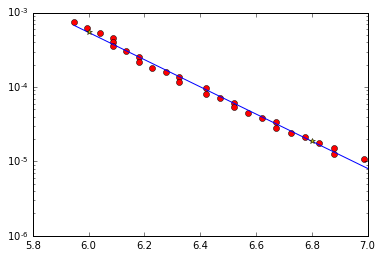

In [19]:
from straightfits import *
df=pd.read_csv('xenon.csv')
x=df.columns[0]
y=df.columns[1]
pf=straightfits(df[x].values,df[y].values)
pf.add_segment(df[x].min(),7)
xx=np.linspace(6,6.9,4)
print pf(xx)
#plt.plot(xx,pf(xx),'r-')
print pf(6)
plt.plot([6],pf(6),'y*')
plt.plot([6.8],pf(6.8),'y*')
print '='*20
print pf.corners
print pf.A
print pf.B
print pf(6.9)

Complete the full range by adding straight line segment and deleting them if necessary

(0.00016440454673914573, -0.58862497515820744)

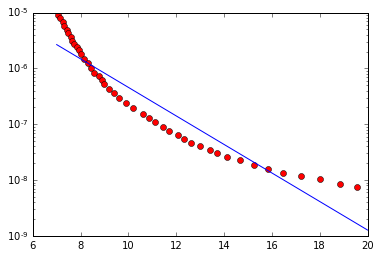

In [20]:
pf.add_segment(7,20)

In [21]:
pf.delete_last_segment()

[  5.94872466   7.          10.        ]
[  0.00000000e+00   5.00210693e+07   8.20879914e-02]
[ 0.         -4.20825252 -1.32064334]
7.93309815073e-06


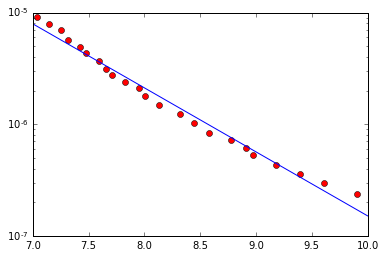

In [22]:
xmax=10
pf.add_segment(7,xmax)
print pf.corners
print pf.A
print pf.B
print pf(7)

[  5.94872466   7.          10.          15.        ]
[  0.00000000e+00   5.00210693e+07   8.20879914e-02   2.48484082e-05]
[ 0.         -4.20825252 -1.32064334 -0.48896146]


7.9330981507279611e-06

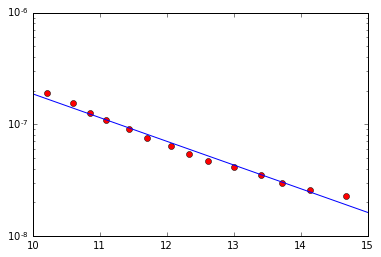

In [23]:
xmax=15
pf.add_segment(10,xmax)
print pf.corners
print pf.A
print pf.B
pf(7)

[  5.94872466   7.          10.          15.          25.        ]
[  0.00000000e+00   5.00210693e+07   8.20879914e-02   2.48484082e-05
   2.02318842e-07]
[ 0.         -4.20825252 -1.32064334 -0.48896146 -0.16399112]


7.9330981507279611e-06

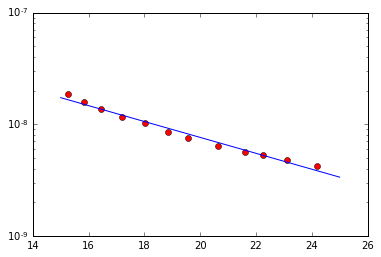

In [24]:
xmax=25
pf.add_segment(15,xmax)
print pf.corners
print pf.A
print pf.B
pf(7)

(1.3074200094767395e-08, -0.050482470449981963)

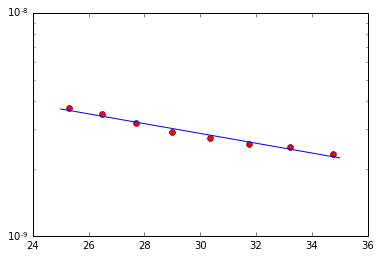

In [25]:
xmax=35
pf.add_segment(25,xmax)

(2.3796910024890402e-09, -0.0023564913676448916)

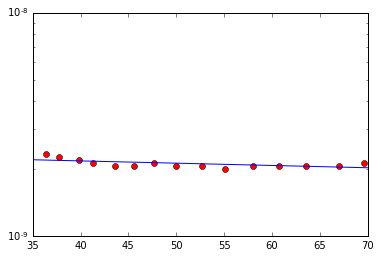

In [26]:
xmax=70
pf.add_segment(35,xmax)

4.8701712612678005e-09

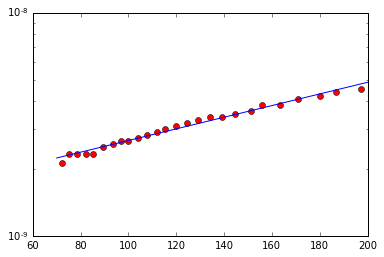

In [27]:
xmax=200
pf.add_segment(70,xmax)
pf(199.9)

4.8556582135649721e-09

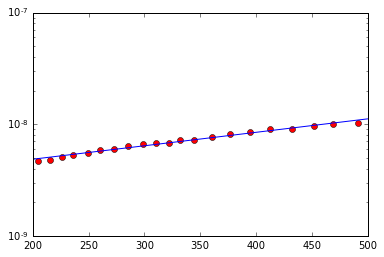

In [28]:
xmax=500
pf.add_segment(200,xmax)
pf(200)

4.8556582135649721e-09

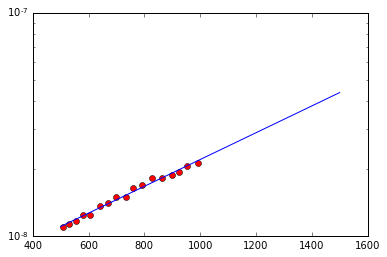

In [29]:
xmax=1500
pf.add_segment(500,xmax)
pf(200)

[  0.00000000e+00   5.00210693e+07   8.20879914e-02   2.48484082e-05
   2.02318842e-07   1.30742001e-08   2.37969100e-09   1.46555154e-09
   2.78787281e-09   5.51645767e-09]
[  0.00000000e+00  -4.20825252e+00  -1.32064334e+00  -4.88961463e-01
  -1.63991118e-01  -5.04824704e-02  -2.35649137e-03   6.00749102e-03
   2.77432897e-03   1.38164211e-03]
[    5.94872466     7.            10.            15.            25.            35.
    70.           200.           500.          1500.        ]


4.8556582135649721e-09

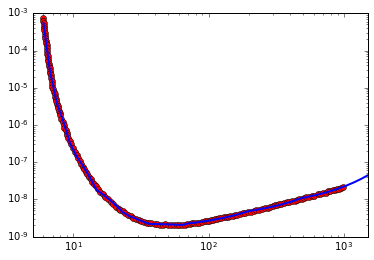

In [30]:
print pf.A
print pf.B
print pf.corners
df=pd.DataFrame()
df['x']=pf.x
df['y']=pf.y
df=df[df.x<=xmax]
plt.loglog(df.x,df.y,'ro')
xx=np.logspace(np.log10(6),np.log10(xmax-0.1))
plt.plot(xx,pf(xx),'b-',lw=2)
plt.xlim(5,xmax)
pf(200)

## Save to file

In [31]:
pf.to_csv('fitxenon.csv')

## Recover fit from file

In [32]:
ff=straightfits()
ff.read_csv('fitxenon.csv')

In [33]:
ff.corners.values[-1:]

array([ 1500.])

(5, array([ 1500.]))

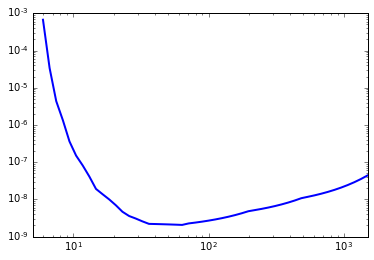

In [34]:
xx=np.logspace( np.log10(ff.corners.values[0]),np.log10(ff.corners.values[-1:]-0.1) )
plt.loglog(xx,ff(xx),'b-',lw=2)
plt.xlim(5,ff.corners.values[-1:])

In [ ]:
%%bash
git commit -am '__getitem__ methord'